###  Modeling: Credit Risk Prediction

- This notebook builds and evaluates multiple classification models for the
German Credit dataset. 
- The objective is to establish strong predictive
baselines that will later be analyzed using explainable AI techniques.

In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# Machine learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, roc_curve,confusion_matrix
import xgboost as xgb
# Setting random seed for reproducibility
seed = 42
np.random.seed(seed)
# plt.style.use('dark_background')
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading cleaned dataset
df = pd.read_csv("statlog_german_credit_data.csv")

In [3]:
# Dropping target variable from features
print("Shape of dataset:", df.shape)
X=df.drop(columns=['class'])
y=df['class']
print("Shape of features:", X.shape)
print("Shape of target:", y.shape)

Shape of dataset: (1000, 21)
Shape of features: (1000, 20)
Shape of target: (1000,)


In [4]:
X.sample(5)

,Status_checking,Duration,Credit_history,Purpose,Credit_amount,Savings,Employment,Installment_rate,Personal_status,Other_debtors,Residence_since,Property,Age,Other_installment_plans,Housing,Number_existing_credits,Job,Number_people_liable,Telephone,Foreign_worker
521,A11,18,A32,A43,3190,A61,A73,2,A92,A101,2,A121,24,A143,A152,1,A173,1,A191,A201
737,A11,18,A32,A40,4380,A62,A73,3,A93,A101,4,A123,35,A143,A152,1,A172,2,A192,A201
740,A11,24,A31,A40,2325,A62,A74,2,A93,A101,3,A123,32,A141,A152,1,A173,1,A191,A201
660,A13,12,A32,A43,1297,A61,A73,3,A94,A101,4,A121,23,A143,A151,1,A173,1,A191,A201
411,A14,33,A34,A41,7253,A61,A74,3,A93,A101,2,A123,35,A143,A152,2,A174,1,A192,A201


In [5]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=seed
)


In [6]:
# Preparing model input pipelines
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns
# Imputing missing values and scaling numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ]
)
# Imputing missing values and one-hot encoding categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]
)
# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [7]:
# Defining standard models without hyperparameter tuning to evaluate: Logistic Regression, Decision Tree, Random Forest, XGBoost
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=seed),
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, random_state=seed, n_jobs=-1
    ),
    "XGBoost": xgb.XGBClassifier(
        enable_categorical=False,
        eval_metric="logloss",
        random_state=seed
    )
}
# Adding input pipeline to each model
pipelines = {
    name: Pipeline(
        steps=[
            ("preprocessing", preprocessor),
            ("model", model)
        ]
    )
    for name, model in models.items()
}

In [8]:
# Model training and evaluation: ROC-AUC, Precision-Recall AUC, Accuracy, F1-Score
results = []
# Training and evaluating each model
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    # Predicting probabilities and classes
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    results.append({
        "Model": name,
        "ROC-AUC": roc_auc_score(y_test, y_proba),
        "PR-AUC": average_precision_score(y_test, y_proba),
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })
# Storing results in a DataFrame
results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
results_df


,Model,ROC-AUC,PR-AUC,Accuracy,F1
2,Random Forest,0.794940,0.902695,0.750,0.833333
0,Logistic Regression,0.759405,0.878716,0.705,0.794425
3,XGBoost,0.745119,0.867417,0.730,0.815068
1,Decision Tree,0.620238,0.755819,0.675,0.765343


- Based on the evaluation metrics, Random Forest outperforms other algorithms achieving the highest ROC-AUC and Precision-Recall AUC, followed by Logistic Regression.


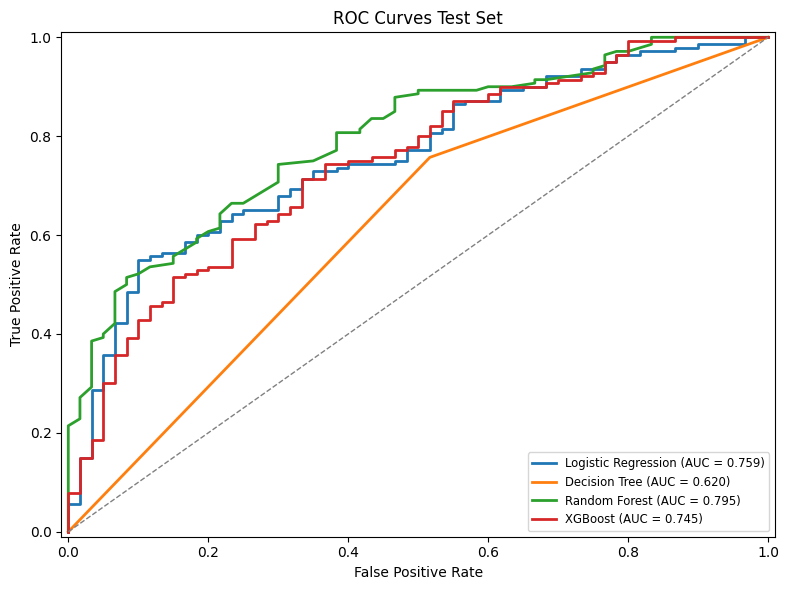

In [9]:
plt.figure(figsize=(8, 6))
for name, pipe in pipelines.items():
    proba = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", linewidth=1)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Test Set")
plt.legend(loc="lower right", fontsize="small")
plt.tight_layout()
plt.show()

- Random Forest dominates the ROC space, followed by Logistic Regression performing competitively across most false positive rates.
- Ensemble models provide stronger discrimination between good and bad credit applicants whereas the Decision Tree lacks in classifying classes performing the worst of all.

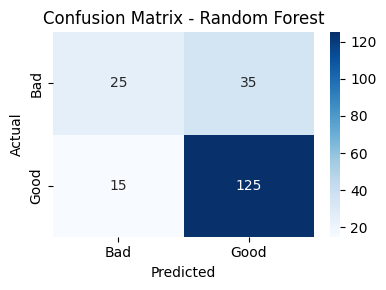

In [10]:
# Plotting confusion matrix for the best model(Random Forest)
best_model = pipelines[results_df.iloc[0]["Model"]]
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Bad", "Good"],
            yticklabels=["Bad", "Good"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {results_df.iloc[0]['Model']}")
plt.tight_layout()
plt.show()


- The model correctly classifies most good credit cases but still approves a considerable number of bad credit applicants.
- This behavior is consistent with the moderate class imbalance identified during EDA, which biases predictions towards good credit class.
- Class imbalance is handled through metric selection rather than using resampling to avoid tinkering with the true risk distribution.

In [11]:
# Cross-validation to assess model stability
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
cv_results = []
for name, pipe in pipelines.items():
    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1
    )
    cv_results.append({
        "Model": name,
        "CV ROC-AUC Mean": scores.mean(),
        "CV ROC-AUC Std": scores.std()
    })
cross_val_df = pd.DataFrame(cv_results).sort_values("CV ROC-AUC Mean", ascending=False)
cross_val_df

,Model,CV ROC-AUC Mean,CV ROC-AUC Std
2,Random Forest,0.789081,0.064578
0,Logistic Regression,0.788207,0.068574
3,XGBoost,0.760603,0.052086
1,Decision Tree,0.607143,0.058420


Performance rankings are consistent across folds, with Random Forest and Logistic Regression showing similar average ROC-AUC and acceptable variance, indicating stable and reliable models rather than overfitting.

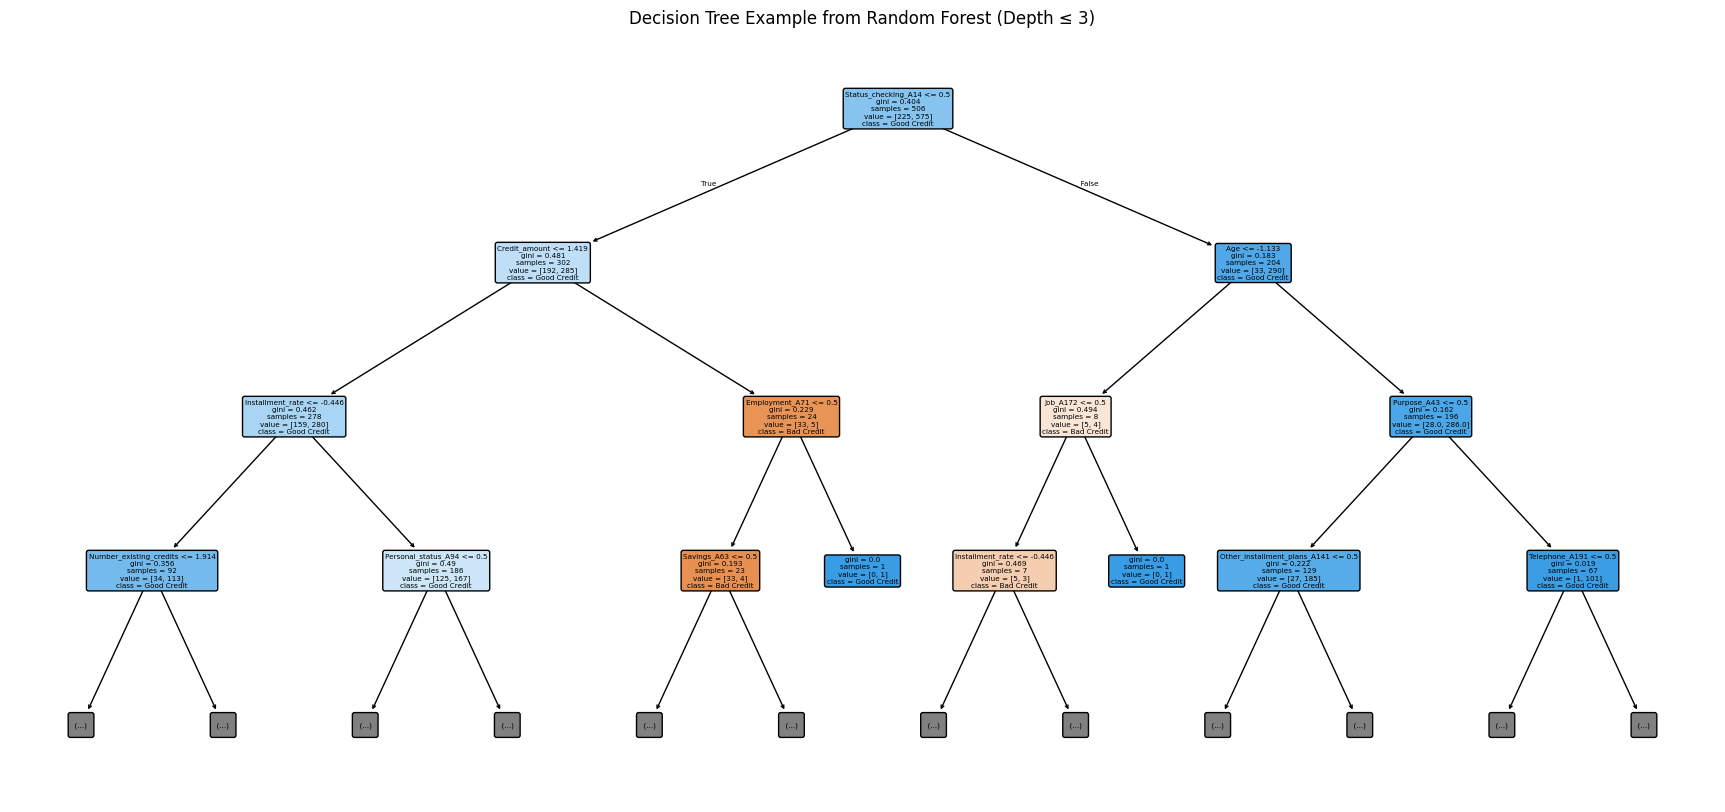

In [12]:
# Visualizing one decision tree from the Random Forest model
rf_pipe = pipelines["Random Forest"]
rf_model = rf_pipe.named_steps["model"]
preproc = rf_pipe.named_steps["preprocessing"]
numeric_features = numeric_cols
categorical_features = preproc.named_transformers_["cat"] \
    .named_steps["onehot"] \
    .get_feature_names_out(categorical_cols)
feature_names = list(numeric_features) + list(categorical_features)
tree = rf_model.estimators_[0]  
plt.figure(figsize=(22, 10))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=["Bad Credit", "Good Credit"],
    filled=True,
    rounded=True,
    max_depth=3
)
plt.title("Decision Tree Example from Random Forest (Depth ≤ 3)")
plt.show()


In [13]:
# Exporting models for explainability (SHAP and LIME)
os.makedirs("models", exist_ok=True)
joblib.dump(pipelines["Random Forest"], "models/random_forest_pipeline.joblib")
joblib.dump(pipelines["Logistic Regression"], "models/logistic_regression_pipeline.joblib")
joblib.dump(pipelines["Decision Tree"], "models/decision_tree_pipeline.joblib")
joblib.dump(pipelines["XGBoost"], "models/xgboost_pipeline.joblib")
# Extracting feature names for later use in explainability
preproc = pipelines["Random Forest"].named_steps["preprocessing"]
numeric_features = numeric_cols
categorical_features = preproc.named_transformers_["cat"] \
    .named_steps["onehot"] \
    .get_feature_names_out(categorical_cols)
feature_names = list(numeric_features) + list(categorical_features)
joblib.dump(feature_names, "models/feature_names.joblib")

['models/feature_names.joblib']

**Conclusion**
- Since the dataset is small and well-structured, standard models capture most of the patterns effectively without extensive hyperparameter tuning. 
- The Random Forest model outperforms others in terms of ROC-AUC and Precision-Recall -AUC, indicating its robustness in handling this classification task.
- Next stage includes implementation of explainability techniques such as SHAP and LIME for all models enabling global and local interpretation of predictions.